In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [2]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 292.4 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


In [3]:
import os
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pyspark 
#sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '32g')])
# here you stop the old spark context with old conf
sc.stop()



Original spark.driver.maxResultSize: 1920m


In [6]:
sc = pyspark.SparkContext(conf=conf)
print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
 

22/12/07 21:00:37 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/12/07 21:00:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/12/07 21:00:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/12/07 21:00:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 32g


In [5]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [6]:
directory = 'gs://msca-bdp-students-bucket/shared_data/linhcle/final_project/clean2/'
# file = '*.json'
# path = directory + file
path = directory

In [7]:
%%time

tweets_df_clean = spark.read.parquet(path)

CPU times: user 4.12 ms, sys: 4.07 ms, total: 8.19 ms
Wall time: 6.99 s


In [13]:
#Shape of dataset
print((tweets_df_sample.count()),len(tweets_df_sample.columns))

30334243 24


In [8]:
#Only choose orginal tweets
tweets_df_sample = tweets_df_clean[tweets_df_clean.retweeted_status_retweet_count.isNull()]

In [15]:
print((tweets_df_sample.count()),len(tweets_df_sample.columns))

10562551 24


In [9]:
#Sample dataset randomly
tweets_df_random = tweets_df_sample.sample(0.005)

In [43]:
tweets_df_random

created_at,id,text,favorite_count,retweet_count,reply_count,retweeted_status_retweet_count,retweeted_status_user_screen_name,tweet_longitude,tweet_latitude,user_created_at,user_id,user_description,user_favourites_count,user_followers_count,user_friends_count,user_location,user_screen_name,user_verified,place_country,place_name,place_full_name,user_type,tweet_type
Mon Apr 25 19:40:...,1518676342593753088,@minimumratpower ...,0,0,0,null,null,null,null,Mon Apr 25 19:25:...,1518671376781090816,big fan of Melain...,0,0,1,null,ShroombiesFan,false,null,null,null,Other,original
Fri Apr 29 02:34:...,1519867803649593344,College basketbal...,0,0,0,null,null,null,null,Thu Feb 13 22:22:...,2342158678,Live music seeker,11445,109,871,null,rorergoff,false,null,null,null,Other,original
Sun Nov 06 03:08:...,1589092241665990657,Scoring the secon...,0,0,0,null,null,null,null,Thu Mar 22 02:21:...,532752544,Data & Analytics ...,13652,25907,671,null,StatsbyLopez,false,null,null,null,Other,original
Sun Nov 06 03:09:...,1589092557086429186,College basketbal...,0,0,0,null,null,null,null,Thu Jan 12 04:46:...,461759120,"Christian, husban...",50343,16328,4226,"Fairfax Station, VA",CaseyMattox_,true,null,null,null,Other,original
Sun Nov 06 03:09:...,1589092634349666304,College football ...,0,0,0,null,null,null,null,Sun Mar 22 01:21:...,25759402,#GoBucks #GoReds ...,24863,948,560,Ohio,Buckeye45,false,null,null,null,Other,original
Sun Nov 06 03:10:...,1589092897223499776,@LauraRutledge @L...,0,0,0,null,null,null,null,Wed Jan 30 19:21:...,1134934638,Understand that w...,8742,398,684,null,MikeMicasherman,false,null,null,null,Other,original
Sun Nov 06 03:11:...,1589092959764779008,@DerwinLGray I ca...,0,0,0,null,null,null,null,Mon May 21 15:24:...,586627328,Partner. Parent. ...,39243,1878,1151,"Durham, Ontario",thatchrischase,false,null,null,null,Other,original
Thu Apr 07 15:00:...,1512082974828683272,A massive thank y...,0,0,0,null,null,null,null,Wed Jun 13 15:16:...,1006918315766353925,GRCC provides cou...,1628,755,1314,"Galway, Ireland",GalwayRCC,false,null,null,null,Other,original
Thu Apr 07 15:01:...,1512083058119229446,Professor Johnson...,0,0,0,null,null,null,null,Wed Sep 15 15:24:...,1438161609852063750,On a mission to m...,616,38,104,New York,Campusgrad,false,null,null,null,Other,original
Tue May 31 14:03:...,1531637417455001601,Triway vs Brecksv...,0,0,0,null,null,null,null,Thu Apr 07 19:04:...,1512144307272110099,Watch Live Stream,0,9,6,United States,HighSch92596186,false,null,null,null,Other,original


In [44]:
print((tweets_df_random.count()),len(tweets_df_random.columns))

52738 24


## Jaccard Similarity

In [10]:
tweet_text = tweets_df_random.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")

tokens = tweet_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [11]:
row = Row('text')
text_df=tweet_text.map(row).zipWithIndex().toDF(['text','id'])
text_df.limit(5)

text,id
{My son and I at ...,2465
{Please stop forc...,2466
{Heritage Christi...,2467
{Richland vs. Sun...,2468
{@dingoposting He...,2469


In [12]:
tweets_df_random.count() 

52616

In [13]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@girlisore, it's, disgrace, actually,,, ogun, state, university, biti, bawo🤦🤦\n\nwhere, put, olabisi, onabanjo..??…, https://t.co/mq811pcfvh]",0
1,"[#jammuandkashmir, entrepreneurship, development, institute, organise, day, long, programme, in, collaboration, with, government, degree, college, kupwara.]",1
2,"[omg, what, college, football, saturday]",2
3,"[lsu, wins, on, the, point, conversion\n\nalabama, and, clemson, lose\n\ncollege, football, is, the, greatest, sport, of, all, time]",3
4,"[scoring, the, second, touchdown, in, college, ot, line, up, for, two, point, conversion,, try, and, draw, opponent, offsides\n\nwors…, https://t.co/p44djwp3u7]",4


In [14]:
# countvectorize
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [15]:
df_vectorize.limit(5).toPandas()

22/12/08 04:58:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB


,list_of_words,id,features
0,"[@girlisore, it's, disgrace, actually,,, ogun, state, university, biti, bawo🤦🤦\n\nwhere, put, olabisi, onabanjo..??…, https://t.co/mq811pcfvh]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[#jammuandkashmir, entrepreneurship, development, institute, organise, day, long, programme, in, collaboration, with, government, degree, college, kupwara.]",1,"(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[omg, what, college, football, saturday]",2,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[lsu, wins, on, the, point, conversion\n\nalabama, and, clemson, lose\n\ncollege, football, is, the, greatest, sport, of, all, time]",3,"(2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[scoring, the, second, touchdown, in, college, ot, line, up, for, two, point, conversion,, try, and, draw, opponent, offsides\n\nwors…, https://t.co/p44djwp3u7]",4,"(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [16]:
# fit MinHashLSH for hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [17]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left')  #.cache()
df_hashed_text.limit(5)

22/12/08 04:58:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 04:59:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 04:59:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:00:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB


id,text,list_of_words,features,hashes
9,{now that i have ...,"[now, that, have,...","(156056,[1,2,5,6,...","[[4045642.0], [1...."
27,{@JoeBiden A $10K...,"[@joebiden, $10k,...","(156056,[3,8,18,4...","[[4.6433962E7], [..."
51,{@ProteususMahon ...,"[@proteususmahon,...","(156056,[1,7,9,66...","[[1.44324431E8], ..."
52,{@blgtylr Truly! ...,"[@blgtylr, truly!...","(156056,[3,7,15,1...","[[1.9601051E8], [..."
56,{Mount Greylock R...,"[mount, greylock,...","(156056,[2,6,20,8...","[[2.78548869E8], ..."


In [18]:
# set similarity threshold, calculate jaccard distance and return near-duplicate record

# med jaccard distance 0.3
jaccard_distance = 0.3

df_dups_text_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')) 

In [19]:
df_dups_30 = df_dups_text_30

In [55]:
records = df_hashed_text.count()
dups_30 = df_dups_text_30.select('id_A').distinct().count()
uniques_30 = records - dups_30

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_30)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques_30)

22/12/07 23:19:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/07 23:21:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/07 23:21:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/07 23:21:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/07 23:29:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/07 23:29:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Total records:  52738
Duplicate titles based on { 0.3 } jaccard distance:  1620
Unique titles based on { 0.3 } jaccard distance:  0.3 :  51118


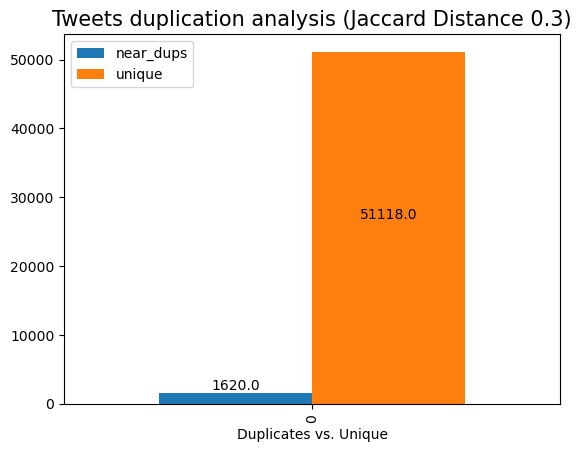

22/12/07 23:32:24 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670446087319_0002_01_000044 on host: hub-msca-bdp-dphub-students-linhcle-sw-njsp.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-07 23:32:24.822]Container killed on request. Exit code is 143
[2022-12-07 23:32:24.822]Container exited with a non-zero exit code 143. 
[2022-12-07 23:32:24.825]Killed by external signal
.
22/12/07 23:32:24 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 44 on hub-msca-bdp-dphub-students-linhcle-sw-njsp.c.msca-bdp-students.internal: Container from a bad node: container_1670446087319_0002_01_000044 on host: hub-msca-bdp-dphub-students-linhcle-sw-njsp.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-07 23:32:24.822]Container killed on request. Exit code is 143
[2022-12-07 23:32:24.822]Container exited with a non-zero exit code 143. 
[2022-12-07 23:32:24.825]Killed by external signal
.
22/12/07 

In [56]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_30], 'unique': [uniques_30]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis (Jaccard Distance 0.3)', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_dups_text_30.show(10)

22/12/07 08:15:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/12/07 08:16:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/12/07 08:16:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/12/07 08:16:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/12/07 08:46:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.6 MiB


+-------------------+-----+-----+--------------------+--------------------+
|            distCol| id_A| id_B|              text_A|              text_B|
+-------------------+-----+-----+--------------------+--------------------+
| 0.2692307692307693|  428| 7326|{If you're lookin...|{If you're lookin...|
|0.18181818181818177|19589|39240|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177| 3525|78169|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|39415|88209|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|59156|92722|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|59156|62856|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|68875|81802|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|88209|92722|{Just posted a ph...|{Just posted a ph...|
|0.18181818181818177|14534|46804|{Just posted a ph...|{Just posted a ph...|
|0.19999999999999996|23882|81769|{Just posted a ph...|{Just posted a ph...|
+-----------

In [20]:
from pyspark.sql.functions import col


def flatten_df(nested_df):
    stack = [((), nested_df)]
    columns = []

    while len(stack) > 0:
        parents, df = stack.pop()

        flat_cols = [
            col(".".join(parents + (c[0],))).alias("_".join(parents + (c[0],)))
            for c in df.dtypes
            if c[1][:6] != "struct"
        ]

        nested_cols = [
            c[0]
            for c in df.dtypes
            if c[1][:6] == "struct"
        ]

        columns.extend(flat_cols)

        for nested_col in nested_cols:
            projected_df = df.select(nested_col + ".*")
            stack.append((parents + (nested_col,), projected_df))

    return nested_df.select(columns)

In [21]:
df_dups_30 = flatten_df(df_dups_text_30)

In [ ]:
df_joined = tweets_df_random.join(df_dups_30, tweets_df_sample['text'] == df_dups_30['text_A_text'], how = 'inner').\
    drop(df_dups_30['text_A_text'])
df_joined

22/12/08 05:00:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/12/08 05:00:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:02:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:02:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:02:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:09:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:09:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:11:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.

created_at,id,text,favorite_count,retweet_count,reply_count,retweeted_status_retweet_count,retweeted_status_user_screen_name,tweet_longitude,tweet_latitude,user_created_at,user_id,user_description,user_favourites_count,user_followers_count,user_friends_count,user_location,user_screen_name,user_verified,place_country,place_name,place_full_name,user_type,tweet_type,distCol,id_A,id_B,text_B_text
Tue Aug 16 00:33:...,1559337572111118337,@NhilaNhils ✧*。Al...,0,0,0,null,null,null,null,Mon Nov 09 15:28:...,1325822468246831109,*.✧ your favorite...,220,483,133,humss grad | 94 GWA,exobaebi,false,null,null,null,University,original,0.2727272727272727,19541,47148,@kylievers ✧*。Alo...
Sat Jun 25 23:58:...,1540846978069925889,@drake11_mj Regis...,0,0,0,null,null,null,null,Sat Mar 19 00:55:...,1504984932116058112,SAC HS FOOTBALL S...,221,374,1323,"Huntsville, AL",sac_alabama,false,null,null,null,Other,original,0.26086956521739135,11646,23380,Register for the ...
Sun May 15 01:33:...,1525650604936204289,Rias Gremory is t...,0,0,0,null,null,null,null,Tue Jul 09 06:03:...,1579583863,Manager. Analyst....,17,1667,290,Touo Academy,riasgremory66,false,null,null,null,Other,original,0.16666666666666663,23012,28876,Rias Gremory is t...
Thu Sep 08 00:04:...,1567665037925388288,@G79125031Amanda ...,0,0,0,null,null,null,null,Tue Jul 19 16:03:...,1549424518954815488,last day i found ...,705,135,4,null,Buzicky4Buzicky,false,null,null,null,Other,original,0.1428571428571429,23780,37577,Happy total secti...
Sat Sep 17 16:43:...,1571177932764086272,@StephanyBrowhaw ...,0,0,0,null,null,null,null,Wed Jul 27 18:18:...,1552357797072871424,regret from the m...,64,120,5,null,A49515152Tricia,false,null,null,null,Other,original,0.1428571428571429,23845,34652,Happy total secti...
Sat Sep 17 16:43:...,1571177932764086272,@StephanyBrowhaw ...,0,0,0,null,null,null,null,Wed Jul 27 18:18:...,1552357797072871424,regret from the m...,64,120,5,null,A49515152Tricia,false,null,null,null,Other,original,0.1428571428571429,23845,39971,@Jone44984687Kim ...
Sat Aug 06 00:49:...,1555717775619923972,Happy total secti...,0,0,0,null,null,null,null,Wed Jun 15 08:31:...,1536989586022633477,streamin is going...,7,155,6,null,Smi21818162Dawn,false,null,null,null,Other,original,0.1428571428571429,23770,26851,Happy total secti...
Sat Aug 06 00:49:...,1555717775619923972,Happy total secti...,0,0,0,null,null,null,null,Wed Jun 15 08:31:...,1536989586022633477,streamin is going...,7,155,6,null,Smi21818162Dawn,false,null,null,null,Other,original,0.1428571428571429,23770,34548,@Kimberl20921151 ...
Fri Oct 28 11:36:...,1585958690393362433,Happy total secti...,0,0,0,null,null,null,null,Sat Sep 03 05:44:...,1565938671991156738,the same items fr...,0,110,4,null,Rebecca10353147,false,null,null,null,Other,original,0.1428571428571429,23888,26049,Happy total secti...
Fri Oct 28 11:36:...,1585958690393362433,Happy total secti...,0,0,0,null,null,null,null,Sat Sep 03 05:44:...,1565938671991156738,the same items fr...,0,110,4,null,Rebecca10353147,false,null,null,null,Other,original,0.1428571428571429,23888,44115,Happy total secti...


### Dups by User Type

In [ ]:
df_joined_unique = df_joined.dropDuplicates()

In [ ]:
df_joined_unique.limit(10)

22/12/08 01:33:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB


In [25]:
# df_joined_unique = df_joined_unique.\
# withColumn("user_type",\
#            when(lower(df_joined.user_description).like('%university%') | lower(df_joined.user_description).like('%college%'), "University").\
#            when(lower(df_joined.user_description).like('%school%'), "School").\
#            when(lower(df_joined.user_description).like('%department%'), "Government Entities").\
#            when(lower(df_joined.user_description).like('%nonprofit%'), "Nonprofit Organization").\
#            when(lower(df_joined.user_description).like('%news%'), "News Outlet").\
#            when(lower(df_joined.user_description).like('%influencer%')| lower(df_joined.user_description).like('%social media%'), "Social Media Influencer").\
#            when(lower(df_joined.user_description).like('%cdc%')| lower(df_joined.user_description).like('%health%') | lower(df_joined.user_description).like('%disease control%'), "Health Organization").\
#            otherwise("Other"))

In [ ]:
df_joined_unique.groupBy(['user_type']).agg(count('id')).orderBy('count(id)',ascending=False).show(10,False)

22/12/08 05:19:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:22:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:22:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:22:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:29:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:29:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:29:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+-----------------------+---------+
|user_type              |count(id)|
+-----------------------+---------+
|Other                  |3690939  |
|Health Organization    |18726    |
|School                 |873      |
|University             |663      |
|News Outlet            |23       |
|Social Media Influencer|8        |
+-----------------------+---------+



In [25]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [26]:
dups_by_type = df_joined_unique.groupBy(['user_type']).agg(count('id')).orderBy('count(id)',ascending=False)

In [ ]:
dups_by_type = dups_by_type.toPandas()

22/12/08 05:29:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:32:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:32:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:33:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:42:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/12/08 05:42:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:42:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:42:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/12/08 05:42:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary w

<AxesSubplot:title={'center':'Number of Similar Tweets by Twitterer Type'}, xlabel='user_type'>

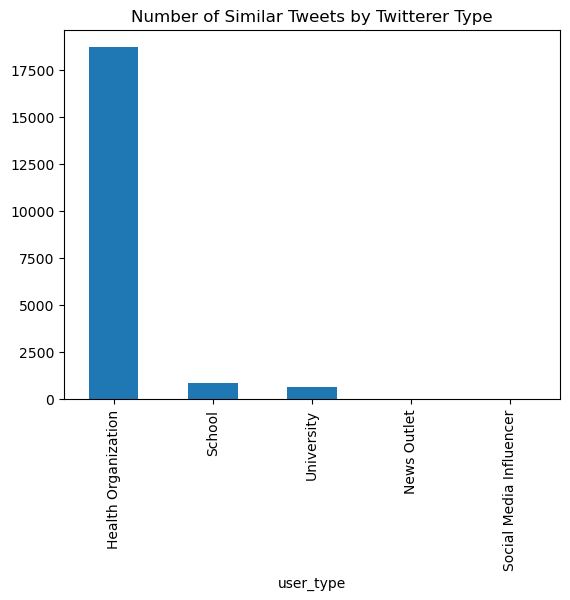

In [ ]:
dups_by_type[dups_by_type.user_type != 'Other'].plot(kind='bar',y='count(id)',x='user_type',legend=None, title="Number of Similar Tweets by Twitterer Type")

<AxesSubplot:title={'center':'Number of Similar Tweets by Twitterer Type'}, xlabel='user_type'>

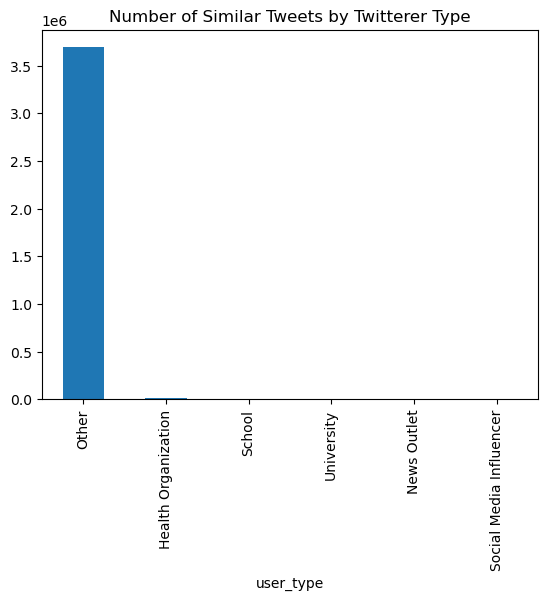

In [ ]:
dups_by_type.plot(kind='bar',y='count(id)',x='user_type',legend=None, title="Number of Similar Tweets by Twitterer Type")

<AxesSubplot:title={'center':'Number of Similar Tweets by Twitterer Type'}, xlabel='user_type'>

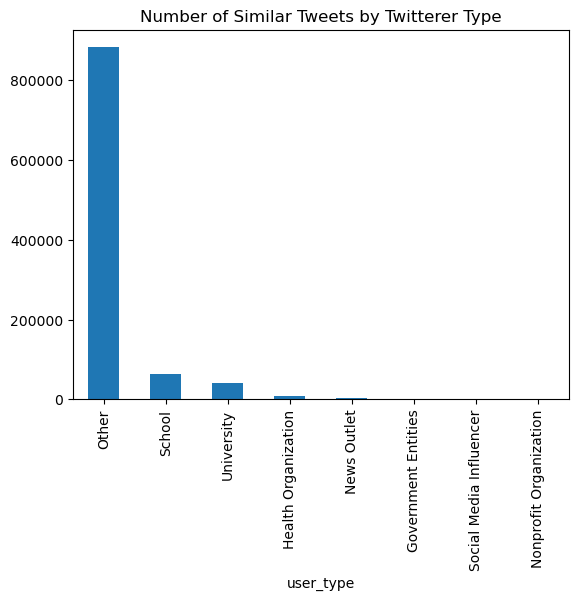

In [50]:
#dups_by_type.plot(kind='bar',y='count(id)',x='user_type',legend=None, title="Number of Similar Tweets by Twitterer Type")

In [ ]:
# 